Note: this includes the code to create the sliding window as well as training TabPFN.



The real training is done in google Colab (for TabPFN, I ended up using XGBoost instead)

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

### 1. Import & set main dataframe
Import dataset, set df as the original reference dataset

Over/under 74.5 points is -120 odds (for players with about even odds). Need to win at least 54.55% of the time to break even at these odds

In [2]:
df = pd.read_csv("./ttennisData/TTCup.csv")
df = df.fillna(0) # G4+ have 

# ------- Create new columns -------
# Combine P1 and P2 scores for each game
for i in range(1, 6):
    df[f'G{i}_Total'] = df[f'P1_G{i}'] + df[f'P2_G{i}']

# Player 1 total score from G1 to G5
df['Total_P1'] = df[[f'P1_G{i}' for i in range(1, 6)]].sum(axis=1)

# Player 2 total score from G1 to G5
df['Total_P2'] = df[[f'P2_G{i}' for i in range(1, 6)]].sum(axis=1)

# Sum of combined scores from G1 to G5
df['Total_Score'] = df[[f'G{i}_Total' for i in range(1, 6)]].sum(axis=1)
df['Over_74'] = df['Total_Score'] > 74

df.rename(columns={'P1_Total': 'Total_P1', 'P2_Total': 'Total_P2'}, inplace=True)

# df['No_Odds'] = (df['Odds_P1'] + df['Odds_P2'] == 0)
# print(df['No_Odds'].sum())

df['Total_Allowed_P1'] = df['Total_P2']
df['Total_Allowed_P2'] = df['Total_P1']

df = df.sort_values(by='Date')
df.info()

/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_12345/2502776621.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./ttennisData/TTCup.csv")


<class 'pandas.core.frame.DataFrame'>
Index: 111380 entries, 111348 to 111379
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              111380 non-null  float64
 1   Player1           111380 non-null  float64
 2   Player2           111380 non-null  float64
 3   Player1_Name      111380 non-null  object 
 4   Player2_Name      111380 non-null  object 
 5   Sets_P1           111380 non-null  float64
 6   Sets_P2           111380 non-null  float64
 7   Odds_P1           111380 non-null  float64
 8   Odds_P2           111380 non-null  float64
 9   P1_G1             111380 non-null  float64
 10  P2_G1             111380 non-null  float64
 11  P1_G2             111380 non-null  float64
 12  P2_G2             111380 non-null  float64
 13  P1_G3             111380 non-null  float64
 14  P2_G3             111380 non-null  float64
 15  P1_G4             111380 non-null  float64
 16  P2_G4             11

In [3]:
df.head()

,Date,Player1,Player2,Player1_Name,Player2_Name,Sets_P1,Sets_P2,Odds_P1,Odds_P2,P1_G1,...,G2_Total,G3_Total,G4_Total,G5_Total,Total_P1,Total_P2,Total_Score,Over_74,Total_Allowed_P1,Total_Allowed_P2
111348,1.612281e+09,329135.0,360367.0,0,0,2.0,3.0,1.27,3.35,11.0,...,18.0,17.0,19.0,22.0,46.0,50.0,96.0,True,50.0,46.0
111347,1.612283e+09,352537.0,328779.0,0,0,1.0,3.0,2.10,1.65,10.0,...,17.0,15.0,18.0,0.0,34.0,38.0,72.0,False,38.0,34.0
111346,1.612286e+09,329135.0,352537.0,0,0,3.0,0.0,1.60,2.20,11.0,...,15.0,13.0,0.0,0.0,33.0,14.0,47.0,False,14.0,33.0
111345,1.612288e+09,376223.0,360367.0,0,0,0.0,3.0,1.85,1.85,5.0,...,12.0,19.0,0.0,0.0,14.0,33.0,47.0,False,33.0,14.0
111344,1.612290e+09,329135.0,376223.0,0,0,1.0,3.0,1.35,2.95,11.0,...,15.0,20.0,19.0,0.0,32.0,42.0,74.0,False,42.0,32.0


### Some rows may contain upcoming data, filter these out
Sept 2026

In [4]:
print(df.shape)
print(f"Number of rows containing upcoming data: {df[df["Total_Score"] == 0].shape}")
df = df[df["Total_Score"] != 0]
print(df.shape)

(111380, 31)
Number of rows containing upcoming data: (26, 31)
(111354, 31)


In [5]:
cont_cols = [
    'Date',
    'Player1',
    'Player2',
    'Sets_P1',
    'Sets_P2',
#    'No_Odds', # Removed from EDA
    'Total_P1',
    'Total_P2',
    'Total_Score',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
]

track_cols = [
    'Date',
    'Sets',
    'Odds',
    'Total',
    'Total_Allowed',
]


y_col = ['H_Won']

# Convert columns to int (it originally was int before odds data was added)
for col in cont_cols:
    df[col] = df[col].astype(np.int64)
cont_cols = cont_cols + ['Over_74','Odds_P1','Odds_P2',]

df = df[cont_cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111354 entries, 111348 to 111349
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              111354 non-null  int64  
 1   Player1           111354 non-null  int64  
 2   Player2           111354 non-null  int64  
 3   Sets_P1           111354 non-null  int64  
 4   Sets_P2           111354 non-null  int64  
 5   Total_P1          111354 non-null  int64  
 6   Total_P2          111354 non-null  int64  
 7   Total_Score       111354 non-null  int64  
 8   Total_Allowed_P1  111354 non-null  int64  
 9   Total_Allowed_P2  111354 non-null  int64  
 10  Over_74           111354 non-null  bool   
 11  Odds_P1           111354 non-null  float64
 12  Odds_P2           111354 non-null  float64
dtypes: bool(1), float64(2), int64(10)
memory usage: 11.2 MB


# 2. Check and remove missing data
from https://www.kaggle.com/code/gpreda/santander-eda-and-prediction

In [6]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [7]:
pd.set_option('display.max_columns', None)
df.dropna()
missing_data(df)

,Date,Player1,Player2,Sets_P1,Sets_P2,Total_P1,Total_P2,Total_Score,Total_Allowed_P1,Total_Allowed_P2,Over_74,Odds_P1,Odds_P2
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Types,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,bool,float64,float64


### 2. Create a dict to track the track_cols array
create another dict to track previous games for each team during the year

In [8]:
track_dict = {}

for row in df.itertuples():
    year = datetime.fromtimestamp(row.Date).year # row.Date.split('-')[0]
    # year = row.Season
    home_team = row.Player1
    visitor_team = row.Player2

    
    # Home or visitor team has < minimum_window total games
    for col in track_cols:
        home_column_name = f'{year}_{home_team}_{col}'
        visitor_column_name = f'{year}_{visitor_team}_{col}'
        
        # Home team
        home_col = col if col == 'Date' else col + '_P1'
        if home_column_name in track_dict:
            track_dict[home_column_name].append(getattr(row, home_col))
        else:
            track_dict[home_column_name] = [getattr(row, home_col)]
        
        # Visitor team
        visitor_col = col if col == 'Date' else col + '_P2'
        if visitor_column_name in track_dict:
            track_dict[visitor_column_name].append(getattr(row, visitor_col))
        else:
            track_dict[visitor_column_name] = [getattr(row, visitor_col)]

### 3. Use track_dict to enforce minimum_window, update df or drop row


In [9]:
print(df.shape)

(111354, 13)


In [10]:
minimum_window = 50
ema_span = 50
print(df.shape)

show_examples = False

indices_to_drop = []
current_count = 0

for row in df.itertuples():
    if current_count % 300 == 0:
        print(f'{current_count}/{df.shape[0]}')
    current_count = current_count + 1
    index = row.Index
    year = datetime.fromtimestamp(row.Date).year # row.Date.split('-')[0]
    # year = row.Season
    home_team = row.Player1
    visitor_team = row.Player2
    # Home team min window
    home_date_column = f'{year}_{home_team}_Date'
    visitor_date_column = f'{year}_{visitor_team}_Date'

    # Drop indice if not enough data
    if len(track_dict[home_date_column]) <= minimum_window or len(track_dict[visitor_date_column]) <= minimum_window:
        indices_to_drop.append(index)
        continue

    # Current row is older than Home team at min_window
    if row.Date <= track_dict[home_date_column][minimum_window]:
        indices_to_drop.append(index)
        continue
    # Current row is older than Visitor team at min_window
    if row.Date <= track_dict[visitor_date_column][minimum_window]:
        indices_to_drop.append(index)
        continue

    home_date_index = track_dict[home_date_column].index(row.Date)
    visitor_date_index = track_dict[visitor_date_column].index(row.Date)
    # print(f'H: {home_date_index} V: {visitor_date_index}')

    # print("----- Track Cols -----")
    # Update df to have average for each track_cols (Ignoring 'Date', the 1-2nd item)
    for col in track_cols:
        if col in ['Date', 'Odds']:
            continue
        else:
            # print(col)
            # Convert to float
            if df.dtypes[col + '_P1'] == 'int64' or df.dtypes[col + '_P2'] == 'int64':
                df = df.astype({f'{col}_P1': 'float64', f'{col}_P2': 'float64'})
            # Update df to have average for each track_cols (Ignoring 'Date', .. items)
            # Update home
            home_col_list = track_dict[f'{year}_{home_team}_{col}'][:home_date_index-1]
            dataframe_val = pd.DataFrame({'value': home_col_list})
            ema = dataframe_val['value'].ewm(span=min(ema_span, len(home_col_list)), adjust=True).mean().iloc[-1]
            df.at[index, col + '_P1'] = ema

            # Update Visitor
            visitor_col_list = track_dict[f'{year}_{visitor_team}_{col}'][:visitor_date_index-1]
            dataframe_val = pd.DataFrame({'value': visitor_col_list})
            ema = dataframe_val['value'].ewm(span=min(ema_span, len(visitor_col_list)), adjust=True).mean().iloc[-1]
            df.at[index, col + '_P2'] = ema


    # --------------------------------------------------- 
    # ------------------ Custom Columns -----------------
    # --------------------------------------------------- 
    
    # 1. Add variant of Bill James pythagorean expectation (NFL).
    # Recent games weighted more heavily since 'Final' columns not excluded from the above loop
    home_points_for = sum(track_dict[f'{year}_{home_team}_Total'][:home_date_index-1])
    home_points_against = sum(track_dict[f'{year}_{home_team}_Total_Allowed'][:home_date_index-1])
    df.at[index, 'pythagorean_P1'] = home_points_for**1.83 / (home_points_for**1.83 + home_points_against**1.83)

    visitor_points_for = sum(track_dict[f'{year}_{visitor_team}_Total'][:visitor_date_index-1])
    visitor_points_against = sum(track_dict[f'{year}_{visitor_team}_Total_Allowed'][:visitor_date_index-1])
    df.at[index, 'pythagorean_P2'] = visitor_points_for**1.83 / (visitor_points_for**1.83 + visitor_points_against**1.83)

df.drop(indices_to_drop, inplace=True)

# Add custom metrics to track_cols so it creates the difference (D_) column
# track_cols.append('pythagorean')
for col in track_cols[1:]:
    cont_cols.append('D_' + col)
    df['D_' + col] = (df[col + '_P1'] - df[col + '_P2']).round(3) # Round to 3 sig figs
    
# Remove columns that begin with H_ or V_ in df
y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
df = df.loc[:, ~(df.columns.str.startswith(('H_', 'V_')) & (~df.columns.isin(y_col)))]

print(df.shape)

(111354, 13)
0/111354
300/111354
600/111354
900/111354
1200/111354
1500/111354
1800/111354
2100/111354
2400/111354
2700/111354
3000/111354
3300/111354
3600/111354
3900/111354
4200/111354
4500/111354
4800/111354
5100/111354
5400/111354
5700/111354
6000/111354
6300/111354
6600/111354
6900/111354
7200/111354
7500/111354
7800/111354
8100/111354
8400/111354
8700/111354
9000/111354
9300/111354
9600/111354
9900/111354
10200/111354
10500/111354
10800/111354
11100/111354
11400/111354
11700/111354
12000/111354
12300/111354
12600/111354
12900/111354
13200/111354
13500/111354
13800/111354
14100/111354
14400/111354
14700/111354
15000/111354
15300/111354
15600/111354
15900/111354
16200/111354
16500/111354
16800/111354
17100/111354
17400/111354
17700/111354
18000/111354
18300/111354
18600/111354
18900/111354
19200/111354
19500/111354
19800/111354
20100/111354
20400/111354
20700/111354
21000/111354
21300/111354
21600/111354
21900/111354
22200/111354
22500/111354
22800/111354
23100/111354
23400/111354


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 74279 entries, 109414 to 111349
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              74279 non-null  int64  
 1   Player1           74279 non-null  int64  
 2   Player2           74279 non-null  int64  
 3   Sets_P1           74279 non-null  float64
 4   Sets_P2           74279 non-null  float64
 5   Total_P1          74279 non-null  float64
 6   Total_P2          74279 non-null  float64
 7   Total_Score       74279 non-null  int64  
 8   Total_Allowed_P1  74279 non-null  float64
 9   Total_Allowed_P2  74279 non-null  float64
 10  Over_74           74279 non-null  bool   
 11  Odds_P1           74279 non-null  float64
 12  Odds_P2           74279 non-null  float64
 13  pythagorean_P1    74279 non-null  float64
 14  pythagorean_P2    74279 non-null  float64
 15  D_Sets            74279 non-null  float64
 16  D_Odds            74279 non-null  float

In [12]:
df.to_csv(f'./ttennisData/TTCupSliding{minimum_window}.csv')

# EDA
### ARFS and feature selection

In [12]:
import arfs
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
import arfs.feature_selection.allrelevant as arfsgroot
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)


In [13]:
df = pd.read_csv(f'./ttennisData/TTCupSliding50.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74279 entries, 0 to 74278
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        74279 non-null  int64  
 1   Date              74279 non-null  int64  
 2   Player1           74279 non-null  int64  
 3   Player2           74279 non-null  int64  
 4   Sets_P1           74279 non-null  float64
 5   Sets_P2           74279 non-null  float64
 6   No_Odds           74279 non-null  int64  
 7   Total_P1          74279 non-null  float64
 8   Total_P2          74279 non-null  float64
 9   Total_Score       74279 non-null  int64  
 10  Total_Allowed_P1  74279 non-null  float64
 11  Total_Allowed_P2  74279 non-null  float64
 12  Over_74           74279 non-null  bool   
 13  Odds_P1           74279 non-null  float64
 14  Odds_P2           74279 non-null  float64
 15  pythagorean_P1    74279 non-null  float64
 16  pythagorean_P2    74279 non-null  float6

(74279, 12)
(74279,)


Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	5
Tentative: 	3
Rejected: 	4
All relevant predictors selected in 00:00:01.91
The selected features: ['Total_P1' 'Total_P2' 'Total_Allowed_P1' 'Total_Allowed_P2' 'D_Odds']
The agnostic ranking: [4 2 1 1 1 1 2 2 5 1 3 5]
The naive ranking: ['Total_Allowed_P2', 'Total_Allowed_P1', 'Total_P1', 'Total_P2', 'D_Odds', 'pythagorean_P2', 'pythagorean_P1', 'Sets_P2', 'D_Total', 'Sets_P1', 'D_Sets', 'D_Total_Allowed']


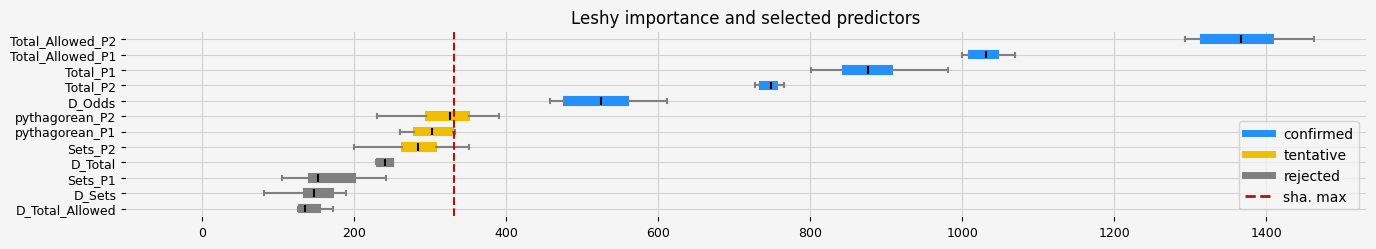

In [16]:
# Load data
x_col = [
    'Sets_P1',
    'Sets_P2',
    'Total_P1',
    'Total_P2',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'pythagorean_P1',
    'pythagorean_P2',
    'D_Sets',
    'D_Odds',
#    'No_Odds',
    'D_Total',
    'D_Total_Allowed'
]

y_col = ['Over_74']
X = df[x_col]
y = df['Over_74']

print(X.shape)
print(y.shape)

model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/arfs/feature_selection/allrelevant.py:1556: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/sha

The selected features: ['Total_P1' 'Total_P2' 'Total_Allowed_P1' 'Total_Allowed_P2'
 'pythagorean_P1' 'pythagorean_P2']
The agnostic ranking: [1 1 2 2 2 2 2 2 1 1 1 1]
The naive ranking: ['Total_Allowed_P2', 'Total_Allowed_P1', 'Total_P1', 'Total_P2', 'pythagorean_P1', 'pythagorean_P2', 'D_Odds', 'Sets_P1', 'Sets_P2', 'D_Total', 'D_Total_Allowed', 'D_Sets']


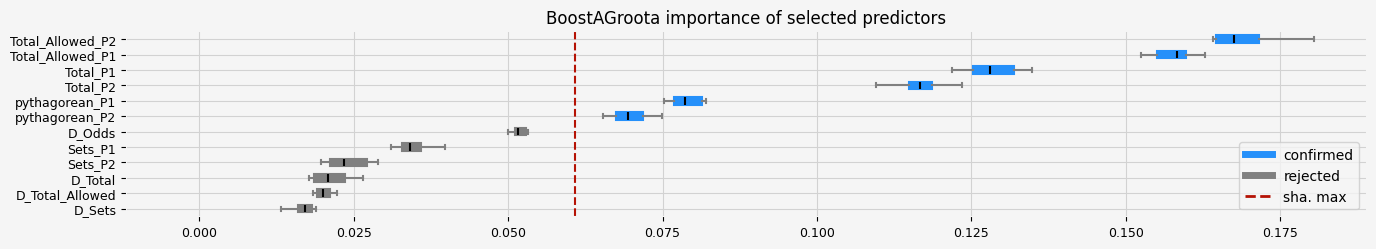

In [17]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

### TabPfn
This was run in google colab, dont run it on your Mac.. It will crash

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tabpfn import TabPFNClassifier
# from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier


slidingDf = pd.read_csv("./ttennisData/TTCupSliding50.csv")

# Load data
x_col = [
    'Sets_P1',
    'Sets_P2',
    'Total_P1',
    'Total_P2',
    # 'Total_Score',
    'Total_Allowed_P1',
    'Total_Allowed_P2',
    'pythagorean_P1',
    'pythagorean_P2',
    'D_Sets',
    'D_Total',
    'D_Total_Allowed'
]

y_col = ['Over_74']
x = slidingDf[x_col]
y = slidingDf[y_col]

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.74, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.85, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(type(y_train))
y_train = y_train.stack().values

# Initialize a classifier
#clf = TabPFNClassifier(ignore_pretraining_limits=True)
# (OLD) clf = AutoTabPFNClassifier(ignore_pretraining_limits=True)
#clf.fit(X_train, y_train)



(11061, 11)
(11061, 1)
<class 'pandas.core.frame.DataFrame'>


/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.12/site-packages/tabpfn/classifier.py:422: UserWarning: Number of samples 11061 is greater than the maximum Number of samples 10000 supported by the model. You may see degraded performance.
  X, y, feature_names_in, n_features_in = validate_Xy_fit(


TabPFNClassifier(ignore_pretraining_limits=True)

In [15]:
X_test_small = X_test[:200]
y_test_small = y_test[:200]
print(X_test_small.shape)
print(y_test_small.shape)
X_test_small.head()

(200, 11)
(200, 1)


,Sets_P1,Sets_P2,Total_P1,Total_P2,Total_Allowed_P1,Total_Allowed_P2,pythagorean_P1,pythagorean_P2,D_Sets,D_Total,D_Total_Allowed
11061,2.168168,1.504759,38.590608,34.940979,38.420650,39.076512,0.493470,0.462656,0.663,3.650,-0.656
11062,2.470990,1.993978,41.657199,38.246055,38.633600,40.695271,0.529376,0.473626,0.477,3.411,-2.062
11063,2.054441,1.783530,37.743366,36.200886,37.559808,36.244615,0.521879,0.502004,0.271,1.542,1.315
11064,2.016241,1.849967,36.790740,39.847974,36.168560,40.438327,0.515551,0.506646,0.166,-3.057,-4.270
11065,2.016812,2.017509,38.283528,37.766878,41.096460,37.645033,0.477448,0.524570,-0.001,0.517,3.451


In [ ]:
# Predict probabilities
prediction_probabilities = clf.predict_proba(X_test_small)
print("ROC AUC:", roc_auc_score(y_test_small, prediction_probabilities[:, 1]))

In [7]:
# Predict labels
predictions = clf.predict(X_test_small)
print("Accuracy", accuracy_score(y_test_small, predictions))

Accuracy 0.56
